In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

Outline:
- Outlier Analysis
- Forecasting Horizon
- Time series cross validation
- Lag features
- Predicting the future

In [16]:
df = pd.read_csv(r"C:\Users\blais\Documents\ML\data\kaggle\PJME_hourly.csv")
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)

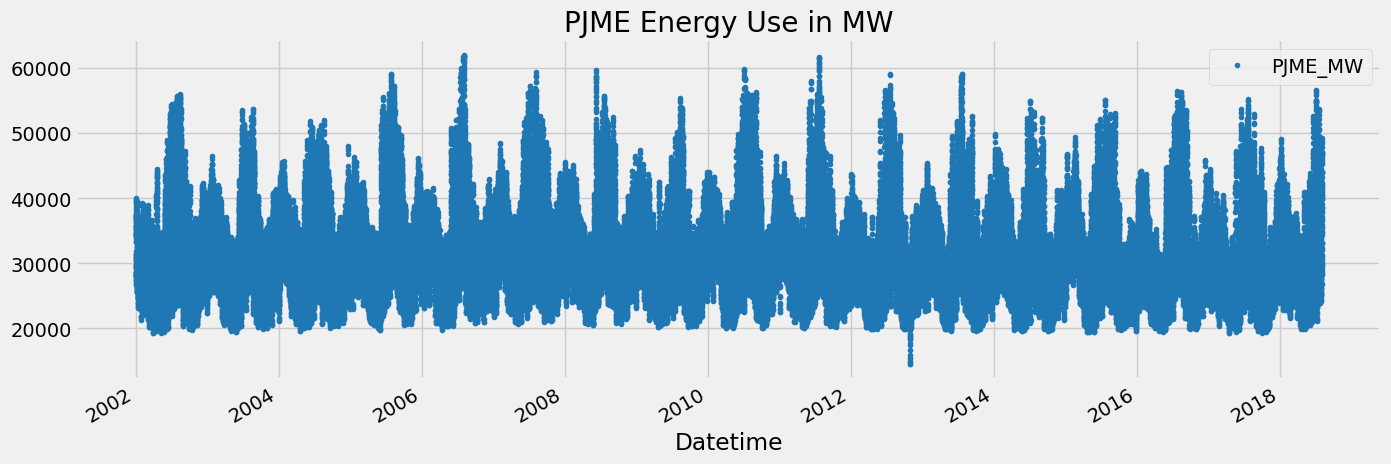

In [17]:
df.plot(style = '.',
        figsize=(15,5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

In [18]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<AxesSubplot:ylabel='Frequency'>

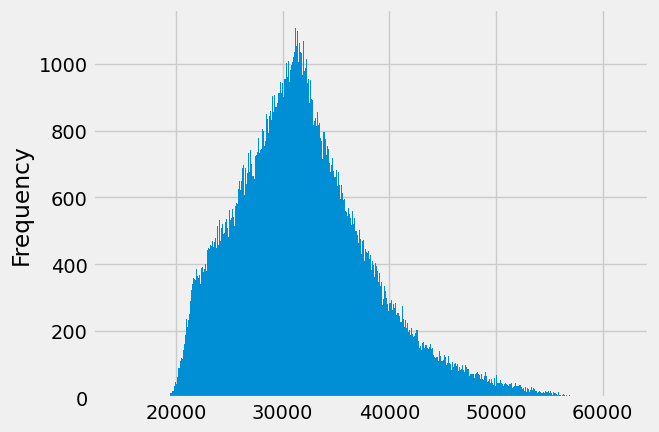

In [19]:
df['PJME_MW'].plot(kind='hist', bins=500)

<AxesSubplot:xlabel='Datetime'>

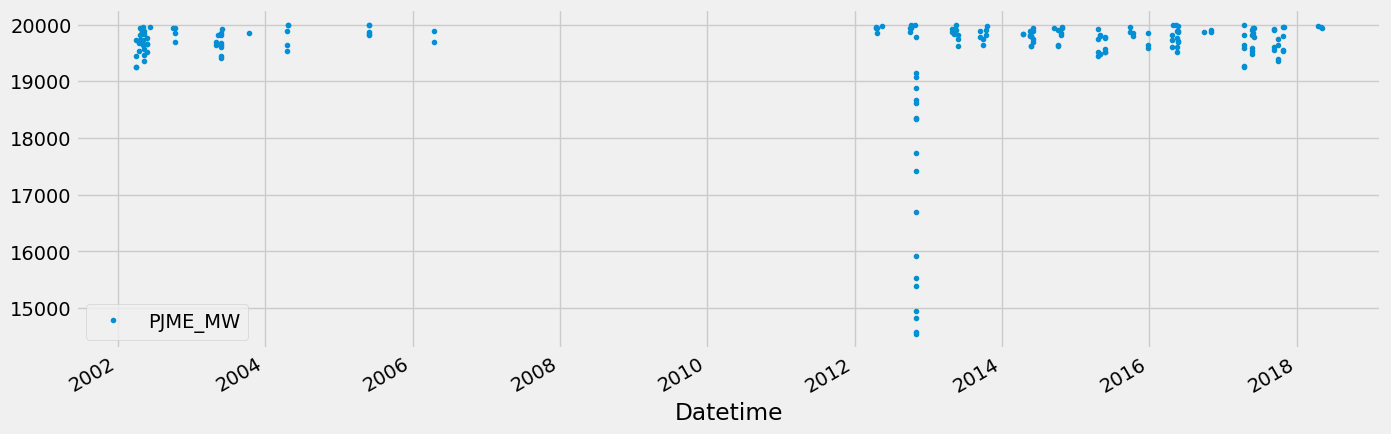

In [8]:
# when are values way lower than 20000
df.query('PJME_MW < 20000').plot(figsize = (15,5), style='.')

We can see that we occasionally have values < 20,000, but some are extreme - way below 20,000

<AxesSubplot:xlabel='Datetime'>

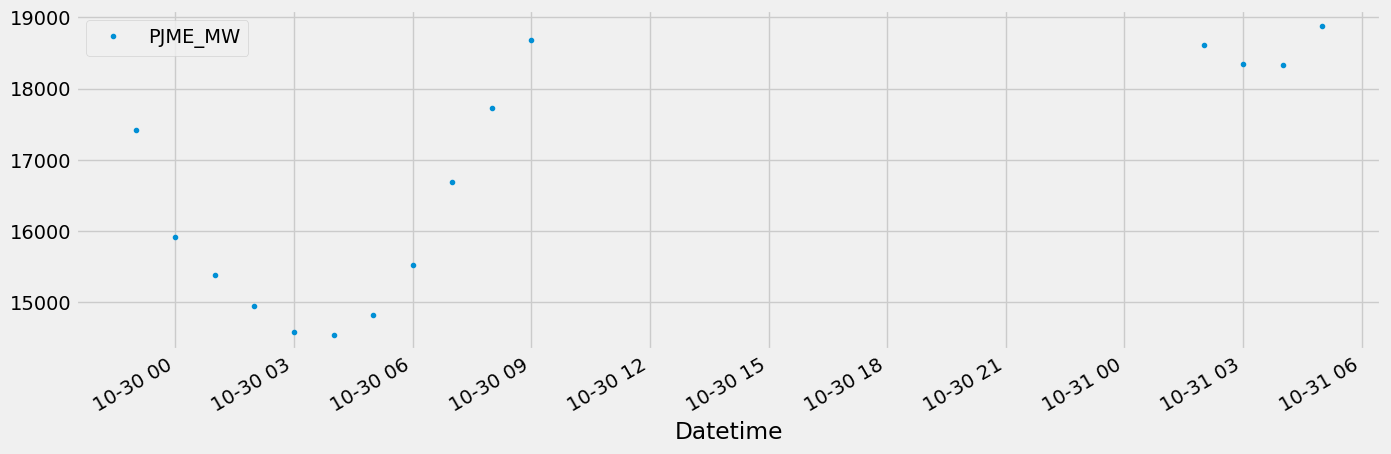

In [9]:
df.query('PJME_MW < 19000').plot(figsize = (15,5), style='.')

this is what we need to remove.

In [20]:
df = df.query('PJME_MW > 19000').copy()

Reviewing: Train/Test Split

Time Series Cross Validation:

In [21]:
from sklearn.model_selection import TimeSeriesSplit

In [22]:
tss = TimeSeriesSplit(n_splits=5, test_size = 24*365*1, gap = 24)
df = df.sort_index()

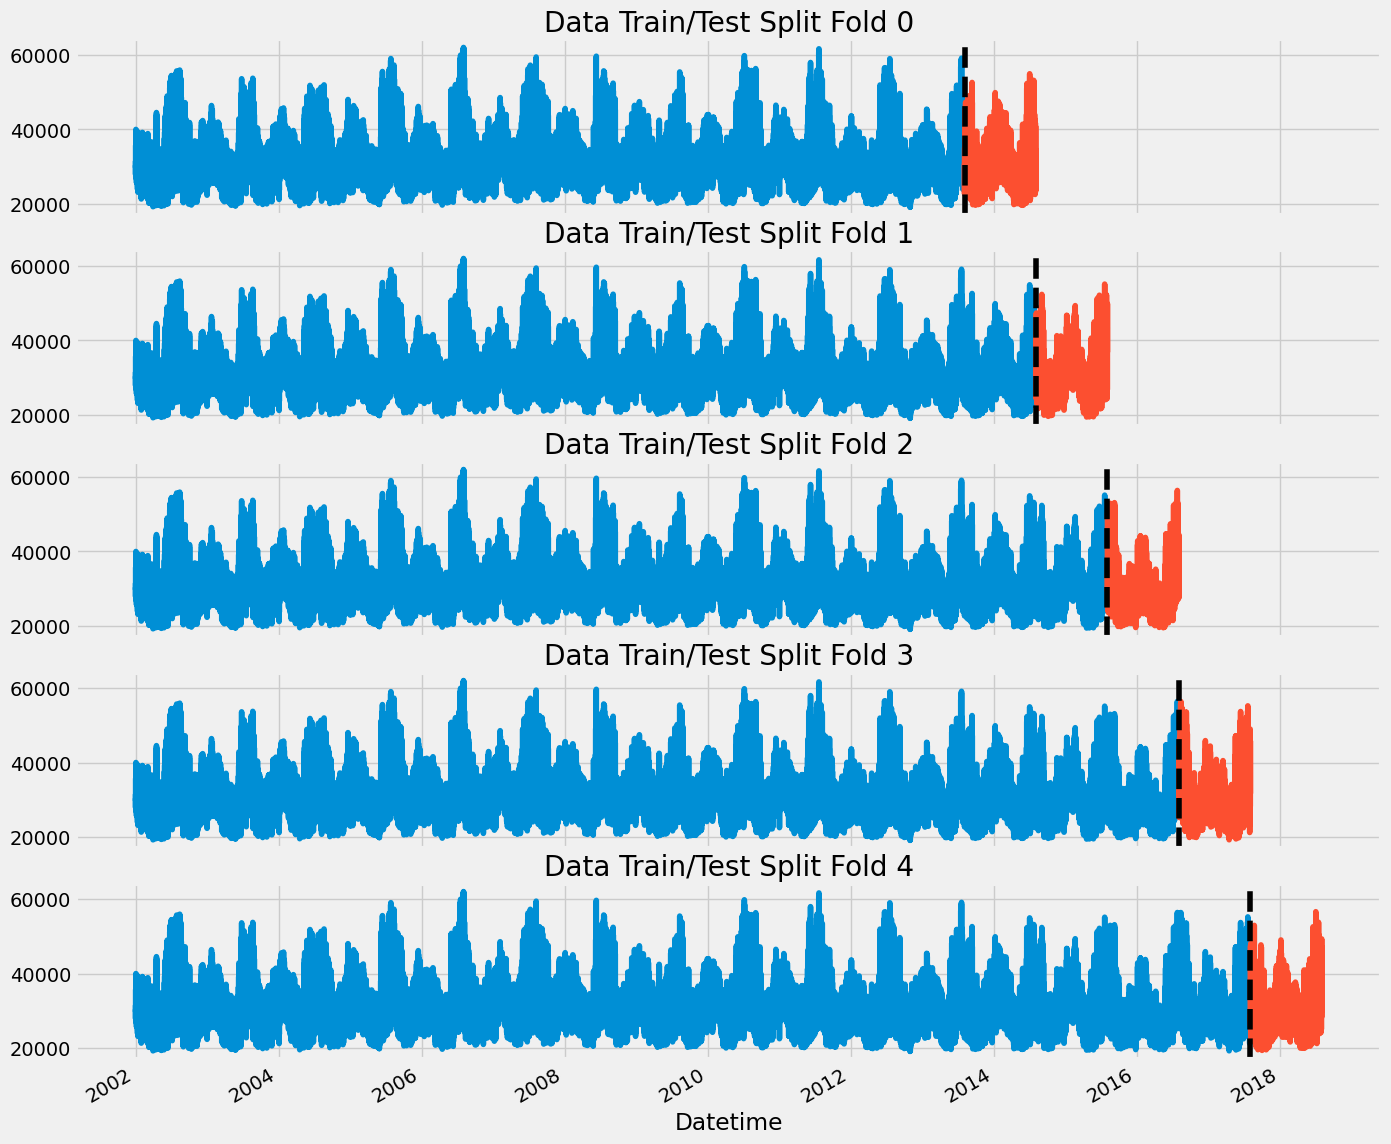

In [23]:
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax = axs[fold], label = 'Training Set', title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax = axs[fold], label = 'Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold+=1
plt.show()

Forecasting Horizon:
- How far out into the future you want to predict. The length of time into the future for which forecasts are to be prepared. These vary from short-term forecasting horizons to long-term forecasting horizons

In [24]:
def create_features(df):
    """
        create time series features based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

In [26]:
import datetime

In [30]:
datetime.timedelta(days=364)

datetime.timedelta(days=364)

In [34]:
datetime.datetime.now().date() - datetime.timedelta(days=365)

datetime.date(2024, 7, 13)

In [39]:
df.index - pd.Timedelta('365 days')

DatetimeIndex(['2001-01-01 01:00:00', '2001-01-01 02:00:00',
               '2001-01-01 03:00:00', '2001-01-01 04:00:00',
               '2001-01-01 05:00:00', '2001-01-01 06:00:00',
               '2001-01-01 07:00:00', '2001-01-01 08:00:00',
               '2001-01-01 09:00:00', '2001-01-01 10:00:00',
               ...
               '2017-08-02 15:00:00', '2017-08-02 16:00:00',
               '2017-08-02 17:00:00', '2017-08-02 18:00:00',
               '2017-08-02 19:00:00', '2017-08-02 20:00:00',
               '2017-08-02 21:00:00', '2017-08-02 22:00:00',
               '2017-08-02 23:00:00', '2017-08-03 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145351, freq=None)

In [38]:
df.index

DatetimeIndex(['2002-01-01 01:00:00', '2002-01-01 02:00:00',
               '2002-01-01 03:00:00', '2002-01-01 04:00:00',
               '2002-01-01 05:00:00', '2002-01-01 06:00:00',
               '2002-01-01 07:00:00', '2002-01-01 08:00:00',
               '2002-01-01 09:00:00', '2002-01-01 10:00:00',
               ...
               '2018-08-02 15:00:00', '2018-08-02 16:00:00',
               '2018-08-02 17:00:00', '2018-08-02 18:00:00',
               '2018-08-02 19:00:00', '2018-08-02 20:00:00',
               '2018-08-02 21:00:00', '2018-08-02 22:00:00',
               '2018-08-02 23:00:00', '2018-08-03 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145351, freq=None)

In [40]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [41]:
df = add_lags(df)

In [42]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN


In [43]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,33539.0,32094.0,31695.0


Training Using Cross Validation:

In [44]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39525.0,38698.0,37330.0


In [48]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap = 24)
df = df.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    # train = create_features(train)
    # test = create_features(test)

    FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear','lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree', n_estimators = 1000, early_stopping_rounds = 50,
                          objective = 'reg:linear', max_depth=3, learning_rate = 0.01)
    reg.fit(X_train, y_train, eval_set = [(X_train, y_train),(X_test, y_test)], verbose=100)

    y_preds = reg.predict(X_test)
    preds.append(y_preds)
    score = root_mean_squared_error(y_test, y_preds)
    scores.append(score)


[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


c:\Users\blais\Documents\ML\venv2\lib\site-packages\xgboost\callback.py:386: UserWarning: [07:06:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[441]	validation_0-rmse:3370.76149	validation_1-rmse:3764.48078
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241
[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373


c:\Users\blais\Documents\ML\venv2\lib\site-packages\xgboost\callback.py:386: UserWarning: [07:06:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.30469
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


c:\Users\blais\Documents\ML\venv2\lib\site-packages\xgboost\callback.py:386: UserWarning: [07:06:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.70202
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.22087
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.46419
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.32356
[410]	validation_0-rmse:3476.66883	validation_1-rmse:3502.25535
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


c:\Users\blais\Documents\ML\venv2\lib\site-packages\xgboost\callback.py:386: UserWarning: [07:06:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12462.36581	validation_1-rmse:12020.28283
[200]	validation_0-rmse:5738.57925	validation_1-rmse:5796.45874
[300]	validation_0-rmse:3918.53218	validation_1-rmse:4388.39477
[400]	validation_0-rmse:3501.24270	validation_1-rmse:4173.36380
[500]	validation_0-rmse:3384.02490	validation_1-rmse:4119.70000
[600]	validation_0-rmse:3325.50024	validation_1-rmse:4105.29234
[700]	validation_0-rmse:3282.73755	validation_1-rmse:4091.57123
[800]	validation_0-rmse:3250.37610	validation_1-rmse:4083.47152
[900]	validation_0-rmse:3223.87814	validation_1-rmse:4081.83008
[999]	validation_0-rmse:3199.82843	validation_1-rmse:4053.00975
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


c:\Users\blais\Documents\ML\venv2\lib\site-packages\xgboost\callback.py:386: UserWarning: [07:06:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12445.87740	validation_1-rmse:11963.42706
[200]	validation_0-rmse:5752.44568	validation_1-rmse:5611.92884
[300]	validation_0-rmse:3951.51709	validation_1-rmse:4156.41403
[400]	validation_0-rmse:3539.25569	validation_1-rmse:4006.58873
[439]	validation_0-rmse:3480.87364	validation_1-rmse:4011.68406


In [49]:
scores

[3760.8277187583353,
 3420.3046881354244,
 3478.018038580526,
 4053.009750964083,
 4001.186553933809]

Predicting the future:
- Train on all data
- Forecast

In [50]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year','dayofyear','lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score = 0.5,
                       booster = 'gbtree',
                       n_estimators = 500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate = 0.01)
reg.fit(X_all, y_all, eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.88991
[100]	validation_0-rmse:12426.83220


c:\Users\blais\Documents\ML\venv2\lib\site-packages\xgboost\training.py:183: UserWarning: [07:11:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[499]	validation_0-rmse:3456.76877


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [51]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [52]:
# create future dataframe
pd.date_range('2018-08-03', '2019-08-01', freq='1h')

DatetimeIndex(['2018-08-03 00:00:00', '2018-08-03 01:00:00',
               '2018-08-03 02:00:00', '2018-08-03 03:00:00',
               '2018-08-03 04:00:00', '2018-08-03 05:00:00',
               '2018-08-03 06:00:00', '2018-08-03 07:00:00',
               '2018-08-03 08:00:00', '2018-08-03 09:00:00',
               ...
               '2019-07-31 15:00:00', '2019-07-31 16:00:00',
               '2019-07-31 17:00:00', '2019-07-31 18:00:00',
               '2019-07-31 19:00:00', '2019-07-31 20:00:00',
               '2019-07-31 21:00:00', '2019-07-31 22:00:00',
               '2019-07-31 23:00:00', '2019-08-01 00:00:00'],
              dtype='datetime64[ns]', length=8713, freq='h')

In [53]:
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')

In [55]:
future_df = pd.DataFrame(index = future)
future_df['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])

In [56]:
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [57]:
future_w_features = df_and_future.query('isFuture').copy()

In [58]:
future_w_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,40666.0,34555.0,34641.0,True


In [59]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

<AxesSubplot:title={'center':'Future Predictions'}>

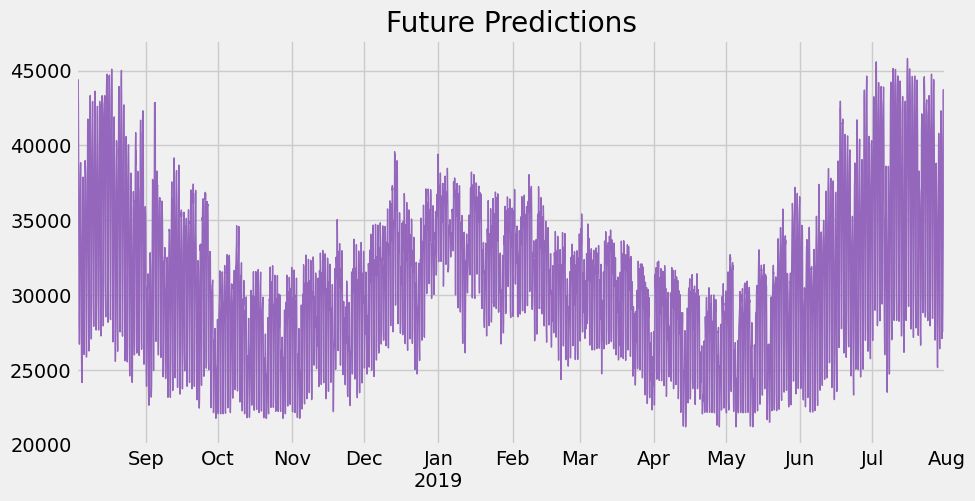

In [60]:
future_w_features['pred'].plot(figsize=(10,5),
                               color=color_pal[4], ms=1, lw=1, title='Future Predictions')

Bonus: saving model for later

In [61]:
reg.save_model('../data/model.json')